In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [13]:
TRAIN_PATH = './training.csv'
TEST_PATH = './test.csv'

def load_data(is_test=False, cols=None):
    """
    기본적으로는 Training 데이터를 로드하되, 테스트 데이터를 로드할 경우에는 is_test 옵션을 준다
    기본적으로 Image 칼럼만 가져오는데, 원하는 칼럼의 경우 cols 에 리스트를 넘긴다
    """
    file_path = TEST_PATH if is_test else TRAIN_PATH
    df = pd.read_csv(file_path)
    # print(df.info())
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        # 만약 더 담을 칼럼이 있다면, 추가해준다
        df = df[list(cols)+['Image']]
    # print(df.count()) # print the number of values for each columns
    df.dropna(inplace=True)
    
    X = np.vstack(df['Image'].values) / 255 # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    
    if not is_test:
        # only training data processing
        y = df[df.columns[:-1]].values
        y = (y-48)/48 # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42) # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X, y

In [14]:
def load_2d_shape(is_test=False, cols=None):
    X, y = load_data(is_test=is_test)
    print('X.shape from load_data ',X.shape)
    X = X.reshape(-1, 96, 96, 1) 
    print('X.shape from reshape ',X.shape)
    return X, y

In [15]:
def plot_sample(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48 + 48, y[1::2]*48 + 48, marker='x', s=10)
    axis.axis('off')

def draw_multi_plot(X, y, row_num=4, col_num=4, fig_size=(15,10)):
    fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=fig_size)
    i=0
    for row in axes:
        for each_ax in row:
            plot_sample(X[i], y[i], each_ax)
            i += 1
    plt.tight_layout()

In [16]:
X, y = load_2d_shape()

X.shape from load_data  (2140, 9216)
X.shape from reshape  (2140, 96, 96, 1)


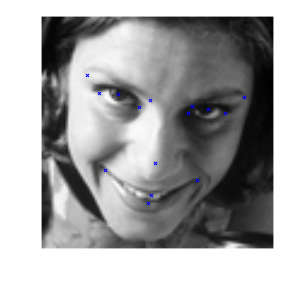

In [17]:
fig, ax = plt.subplots()
plot_sample(X[1], y[1], ax)
plt.tight_layout()

In [18]:
def make_config():
    config_dict = {
        "nb_epoch":10,
        "batch_size":128,
        "img_rows":96,
        "img_cols":96,
        "nb_filters_1":32,
        "nb_filters_2":64,
        "nb_filters_3":128,
        "nb_conv":3
    }
    return config_dict

In [19]:
config = make_config()

In [20]:
import keras.models as models
import keras.layers.convolutional as conv
import keras.layers.core as core

Using TensorFlow backend.


In [21]:
cnn = models.Sequential()
cnn

In [22]:
cnn.add(conv.Convolution2D(config['nb_filters_1'], 3, 3, activation='relu', input_shape=(96, 96, 1), border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2,2)))
cnn.add(core.Dropout(0.2))

cnn.add(conv.Convolution2D(config['nb_filters_2'], 3, 3, activation='relu', border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2,2)))


cnn.add(core.Flatten())
cnn.add(core.Dropout(0.2))
cnn.add(core.Dense(500, activation='relu'))
cnn.add(core.Dense(500, activation='relu'))
cnn.add(core.Dense(30, activation='softmax')) # softmax 에 넣고 클래스를 분류할 수 있도록 한다

In [23]:
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 96, 96, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 48, 48, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 48, 48, 32)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 48, 48, 64)    18496       dropout_1[0][0]                  
___________________________________________________________________________________________

In [24]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn

In [25]:
cnn.fit(X, y, nb_epoch=config['nb_epoch'], verbose=1)

Epoch 1/10
2140/2140 [==============================] - 87s - loss: -64.8524 - acc: 0.3407    
Epoch 2/10
2140/2140 [==============================] - 87s - loss: -71.7057 - acc: 0.6603    
Epoch 3/10
2140/2140 [==============================] - 83s - loss: -71.7187 - acc: 0.6855    
Epoch 4/10
2140/2140 [==============================] - 87s - loss: -71.7265 - acc: 0.7000    
Epoch 5/10
2140/2140 [==============================] - 90s - loss: -71.7377 - acc: 0.6902    
Epoch 6/10
2140/2140 [==============================] - 84s - loss: -71.7434 - acc: 0.6953    
Epoch 7/10
2140/2140 [==============================] - 84s - loss: -71.7612 - acc: 0.6963    
Epoch 8/10
2140/2140 [==============================] - 85s - loss: -71.7924 - acc: 0.7168    
Epoch 9/10
2140/2140 [==============================] - 78s - loss: -71.8712 - acc: 0.6771    
Epoch 10/10
2140/2140 [==============================] - 86s - loss: -71.9642 - acc: 0.5907    


In [26]:
y_pred = cnn.predict(X)
y_pred

array([[  7.70376027e-02,   4.96325054e-15,   3.04948230e-15, ...,
          1.07711032e-01,   1.24735507e-07,   1.29835740e-01],
       [  7.49153346e-02,   1.44747929e-12,   1.05856632e-12, ...,
          1.29913509e-01,   5.87111899e-05,   1.14105836e-01],
       [  7.37798288e-02,   1.84536509e-13,   1.46776647e-13, ...,
          1.19194984e-01,   3.33160551e-06,   1.21044673e-01],
       ..., 
       [  8.43189433e-02,   9.45941936e-11,   7.34528341e-11, ...,
          9.26859379e-02,   2.87624098e-05,   1.37950271e-01],
       [  7.19762594e-02,   9.79606587e-13,   7.17710505e-13, ...,
          1.15910880e-01,   5.84637007e-07,   1.32653296e-01],
       [  8.19494426e-02,   5.09708248e-12,   4.27670442e-12, ...,
          9.56468359e-02,   2.52025027e-04,   1.26717269e-01]], dtype=float32)

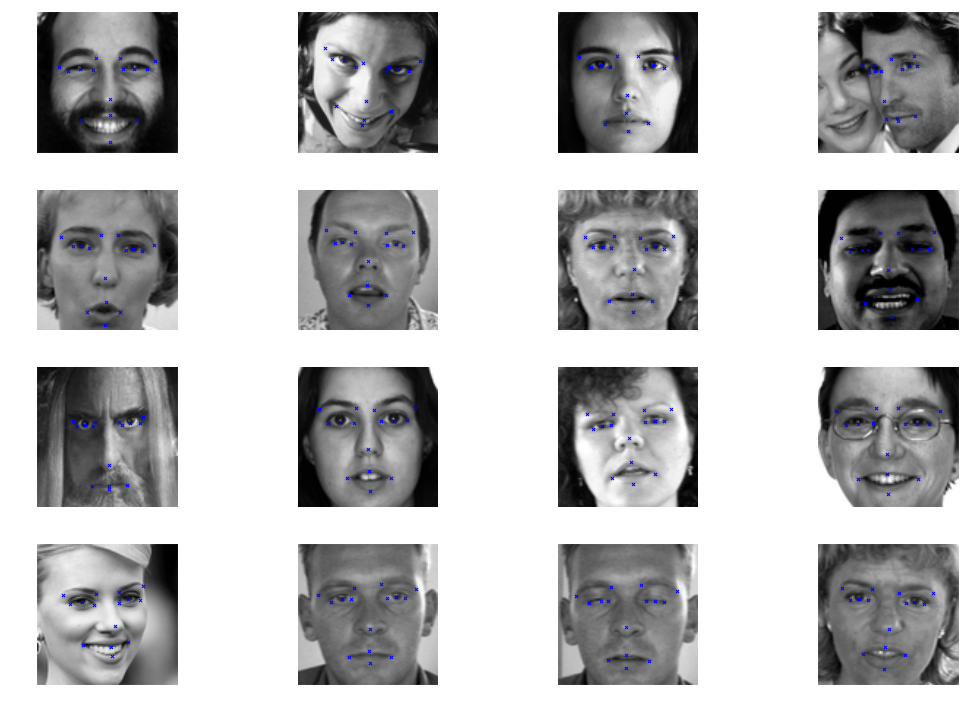

In [27]:
draw_multi_plot(X, y)

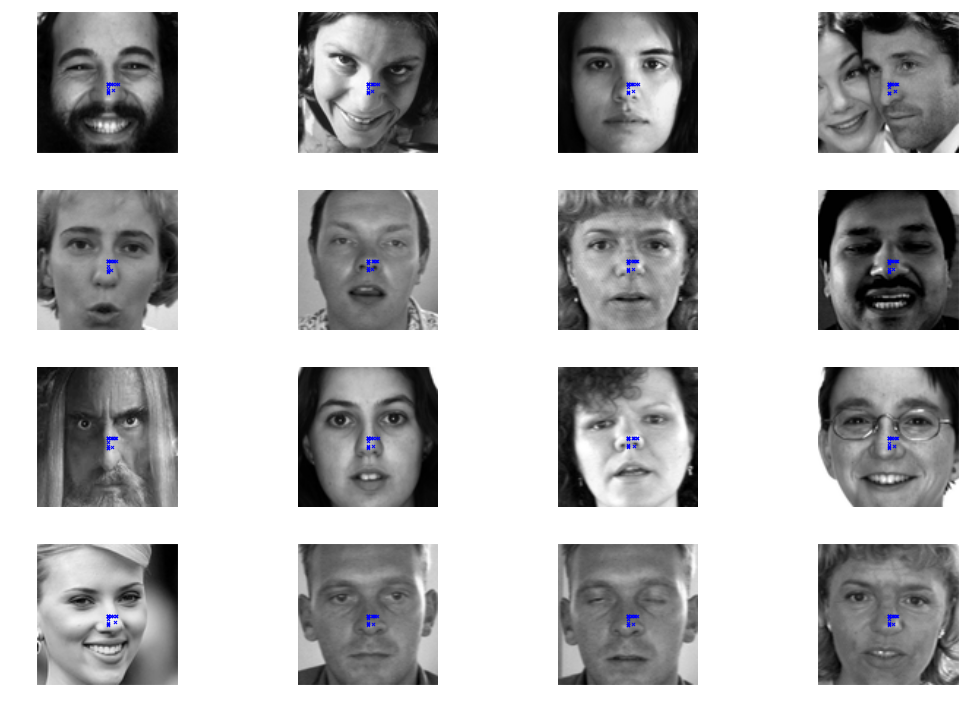

In [28]:
draw_multi_plot(X, y_pred)